<a href="https://colab.research.google.com/github/francoisdoanp/projects/blob/master/Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MATH60121 - ROTTEN TOMATOES PROJECT**

---


The goal of this project explore two aspects of text mining: sentiment analysis and text summarization. To do so, we will use the context of Rotten Tomatoes, a popular movie review aggregation website. The user is presented short summaries of reviews by various critics, and a score is assigned: rotten or fresh.

As such, our project will be divided in two parts. The first part is to train a model to accurately predict if a movie is fresh or rotten based on the short summary. For this task, we will use Nicolas Gervais' rotten tomatoes dataset, available [here](https://https://github.com/francoisdoanp/rotten-tomatoes-dataset).

In the second part, we will attempt to summarize movie reviews from the Rolling Stone magazine, which rates its movies on 5 stars. Finally, we will use our model to predict whether our summary indicates a fresh or rotten score, which we can verify based on the stars. If our summarization is pertinent, then it should indicate whether the critic's sentiment towards that movie.




# Part 1: Sentiment Analysis

---



In [ ]:
# Importing libraries

import pandas as pd
import numpy as np
import re
import statistics

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output

from nltk.corpus import stopwords, inaugural
import re
import spacy


import networkx as nx
from scipy import sparse


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
# Uploading Dataset

url_base = 'https://raw.githubusercontent.com/francoisdoanp/rotten-tomatoes-dataset/master/small_rotten.txt'

rotten_db = pd.read_csv(url_base)

### Exploratory analysis

In [ ]:
# Structure of the dataset

print(rotten_db.head)

# Examples of Fresh and Rotten movie reviews
print('Fresh review:', rotten_db['Review'][1])
print('Rotten review:', rotten_db['Review'][0])

<bound method NDFrame.head of         Freshness                                             Review
0               1  Manakamana doesn't answer any questions, yet m...
1               1  Wilfully offensive and powered by a chest-thum...
2               0  It would be difficult to imagine material more...
3               0  Despite the gusto its star brings to the role,...
4               0  If there was a good idea at the core of this f...
...           ...                                                ...
158395          0  Sean Anders' witless, embarrassingly puerile s...
158396          0  "The Water Diviner" just wants to tell an old-...
158397          0  Whatever most of the filmmakers here were tryi...
158398          1  You can't help but empathize with the people y...
158399          1  works in its own right as a semi-campy gloss o...

[158400 rows x 2 columns]>
Fresh review: Wilfully offensive and powered by a chest-thumping machismo, but it's good clean fun.
Rotten review:

1    79326
0    79074
Name: Freshness, dtype: int64


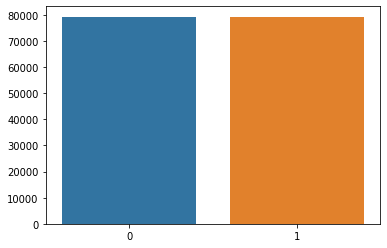

In [ ]:
# Distribution of fresh vs rotten

dist = rotten_db['Freshness'].value_counts()
print(dist)
sns.barplot(dist.index, dist.values)

### Preprocessing

In [ ]:
# Removing end of sentences' full content available message

test_c = "Decent enough as an action pic but sorely needing some Schwarzenegger ""magic."" (Full Content Review for Parents also available)"
test2_c = "Aside from a few jokes and some puns related to birds and the eventual invading pig population, this is a pretty lame exercise. (Full Content Review for Parents - Violence, Sexual Content, etc. - Also Available)"
test3_c = "While fans of the original work might get into this filmed adaptation, I came in cold and left even chillier in terms of appreciating what the movie was trying to be and how all of that was executed. (Full Content Review for Pare"

res_c = re.sub(r'\(Full Content.*$', " ", test_c)

print("Original Sentence:", test_c, "\nModified Sentence:", res_c)


Original Sentence: Decent enough as an action pic but sorely needing some Schwarzenegger magic. (Full Content Review for Parents also available) 
Modified Sentence: Decent enough as an action pic but sorely needing some Schwarzenegger magic.  


In [ ]:
# Removing end of sentences' Spanish translation Notice

test_s = "Thor: Ragnarock is a party and everyone is invited. [Full Review in Spanish]"

res_s = re.sub(r'\[Full Re.*$', " ", test_s)

print("Original Sentence:", test_s, "\nModified Sentence:", res_s)

Original Sentence: Thor: Ragnarock is a party and everyone is invited. [Full Review in Spanish] 
Modified Sentence: Thor: Ragnarock is a party and everyone is invited.  


In [ ]:
# Removing video format notice

test_f = "[VIDEO ESSAY] ""Wild"" is an unsatisfying self-help drama that exposes the limitations of Reece Witherspoon's range."
test2_f = "[VIDEO] There's nothing flashy about David Gelb's serviceable rendering of a man who has achieved an unrivaled mastery of a cuisine he helped invent. You too might come away from the movie dreaming of Jiro Ono's sushi."

res_f = re.sub(r'\[VID.*\]', "", test2_f)

print("Original Sentence:", test_f, "\nModified Sentence:", res_f)

Original Sentence: [VIDEO ESSAY] Wild is an unsatisfying self-help drama that exposes the limitations of Reece Witherspoon's range. 
Modified Sentence:  There's nothing flashy about David Gelb's serviceable rendering of a man who has achieved an unrivaled mastery of a cuisine he helped invent. You too might come away from the movie dreaming of Jiro Ono's sushi.


In [ ]:
# Separating in features and labels

reviews = rotten_db['Review'].values
labels = rotten_db['Freshness'].values

# Preparing test reviews 

test1 = reviews[5]
test2 = reviews[6]
test3 = reviews[7]
test4 = reviews[11]
test5 = reviews[13]

processed_reviews = []

for rev in range(0, len(reviews)):

  # Removing special instances as demonstrated previousy
  processed_review = re.sub(r'\(Full Content.*$', " ", str(reviews[rev]))
  processed_review = re.sub(r'\[Full Re.*$', " ", processed_review)
  processed_review = re.sub(r'\[VID.*\]', "", processed_review)

  # Removing special characters
  processed_review = re.sub(r'\W', ' ', processed_review)

  # Removing single characters
  processed_review = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_review)
  processed_review = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_review)

  # Removing multiple spaces
  processed_review = re.sub(r'\s+', ' ', processed_review, flags=re.I)
  processed_review = re.sub(r'\^\s+', '', processed_review, flags=re.I)

  # Transform reviews to lower case
  processed_review = processed_review.lower()

  processed_reviews.append(processed_review)

In [ ]:
print("Original Sentence:", reviews[5], "\nModified Sentence:", processed_reviews[5], "\n\nOriginal Sentence:", reviews[6], "\nModified Sentence:", processed_reviews[6],
      "\n\nOriginal Sentence:", reviews[7], "\nModified Sentence:", processed_reviews[7], "\n\nOriginal Sentence:", reviews[11], "\nModified Sentence:", processed_reviews[11],
      "\n\nOriginal Sentence:", reviews[13], "\nModified Sentence:", processed_reviews[13])

Original Sentence: Gleeson goes the Hallmark Channel route, damaging an intermittently curious entry in the time travel subgenre. 
Modified Sentence: gleeson goes the hallmark channel route damaging an intermittently curious entry in the time travel subgenre  

Original Sentence: It was the height of satire in 1976: dark as hell, but patently absurd and surely nowhere close to objective reality. Objective reality surpassed it somewhere in the Jerry Springer era. 
Modified Sentence: it was the height of satire in 1976 dark as hell but patently absurd and surely nowhere close to objective reality objective reality surpassed it somewhere in the jerry springer era  

Original Sentence: Everyone in "The Comedian" deserves a better movie than "The Comedian." 
Modified Sentence: everyone in the comedian deserves better movie than the comedian  

Original Sentence: ... except for its shamelessly (and irresistibly) zingy music score (by the director), Halloween achieves its considerable power a

In [ ]:
# Creating list of reviews

X = list(rotten_db['Review'])
Y = np.array(list(rotten_db['Freshness']))

for i in range(1, 10):
    print(X[i], '\n' , Y[i])


Wilfully offensive and powered by a chest-thumping machismo, but it's good clean fun. 
 1
It would be difficult to imagine material more wrong for Spade than Lost & Found. 
 0
Despite the gusto its star brings to the role, it's hard to ride shotgun on Hector's voyage of discovery. 
 0
If there was a good idea at the core of this film, it's been buried in an unsightly pile of flatulence jokes, dog-related bad puns and a ridiculous serial arson plot. 
 0
Gleeson goes the Hallmark Channel route, damaging an intermittently curious entry in the time travel subgenre. 
 0
It was the height of satire in 1976: dark as hell, but patently absurd and surely nowhere close to objective reality. Objective reality surpassed it somewhere in the Jerry Springer era. 
 1
Everyone in "The Comedian" deserves a better movie than "The Comedian." 
 0
Actor encourages grumpy Christians to embrace the season. 
 0
Slight, contained, but ineffably soulful. 
 1


#Part 2 : Test d'un premier modèle

In [ ]:
rotten_db['Review'] = processed_reviews

# test
print(processed_reviews[5], "\n", rotten_db['Review'][5])

# Splitting the dataset into train and test set
train, test = train_test_split(rotten_db,test_size = 0.1)

gleeson goes the hallmark channel route damaging an intermittently curious entry in the time travel subgenre  
 gleeson goes the hallmark channel route damaging an intermittently curious entry in the time travel subgenre 


Positive words


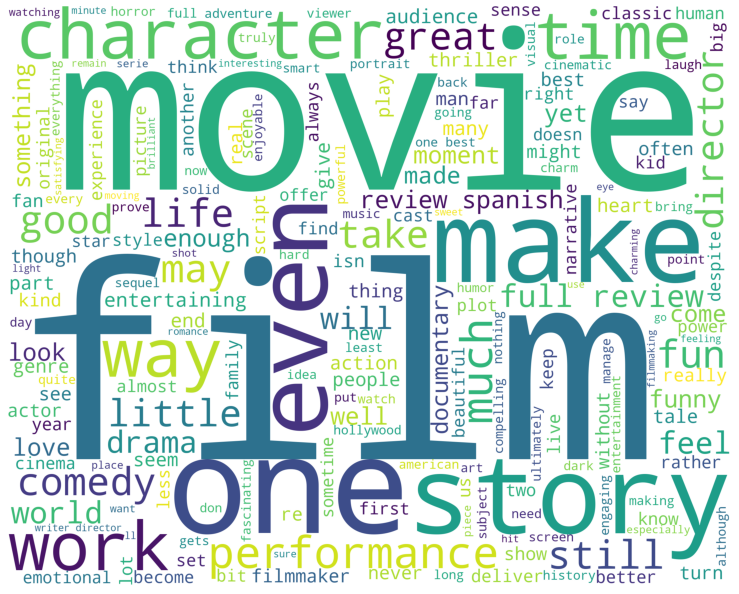

Negative words


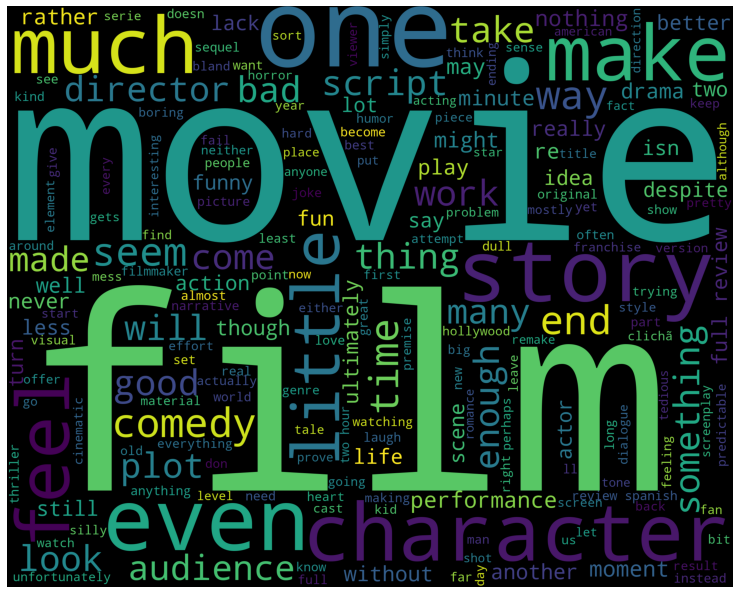

In [ ]:
train_pos = train[ train['Freshness'] == 1]
train_pos = train_pos['Review']
train_neg = train[ train['Freshness'] == 0]
train_neg = train_neg['Review']

test_pos = test[ test['Freshness'] == 1]
test_pos = test_pos['Review']
test_neg = test[ test['Freshness'] == 0]
test_neg = test_neg['Review']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

Les mots "Film" et "Movie seraient clairement à retirer, ainsi que d'autres stopwords.
Mais on peut essayer de se servir uniquement des adjectifs

In [ ]:
files_pos = rotten_db[ rotten_db['Freshness'] == 1]
files_neg = rotten_db[ rotten_db['Freshness'] == 0]

files_pos = files_pos[:50000]
files_neg = files_neg[:50000]

all_words = []
documents = []

stop_words = list(set(stopwords.words('english')))

#  j is adject, r is adverb, and v is verb
# allowed_word_types = ["J","R","V"]
allowed_word_types = ["J"]

for p in  files_pos['Review']:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    documents.append( (p, "pos") )
    
    # remove punctuations
    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p)
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    pos = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())
   
for p in files_neg['Review']:
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    documents.append( (p, "neg") )
    
    # remove punctuations
    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p)
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    neg = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in neg:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [ ]:
len(all_words)

266808

In [ ]:
# creating a frequency distribution of each adjectives.
all_words = nltk.FreqDist(all_words)

# listing the 5000 most frequent words
word_features = list(all_words.keys())[:5000]

# function to create a dictionary of features for each review in the list document.
# The keys are the words in word_features 
# The values of each key are either true or false for wether that feature appears in the review or not

def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

# Creating features for each review
featuresets = [(find_features(rev), category) for (rev, category) in documents]

# Splitting the dataset into train and test set
training_set, testing_set = train_test_split(featuresets,test_size = 0.4)

traintest, testtest = train_test_split(features,test_size = 0.4)

NameError: ignored

In [ ]:
len(training_set)

60000

In [ ]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

classifier.show_most_informative_features(15)

Classifier accuracy percent: 71.3175
Most Informative Features
                 unfunny = True              neg : pos    =     40.3 : 1.0
                lifeless = True              neg : pos    =     40.2 : 1.0
                    lame = True              neg : pos    =     28.3 : 1.0
               masterful = True              pos : neg    =     21.9 : 1.0
                   tepid = True              neg : pos    =     20.5 : 1.0
               pointless = True              neg : pos    =     18.2 : 1.0
                  shoddy = True              neg : pos    =     15.6 : 1.0
               observant = True              pos : neg    =     15.0 : 1.0
                  dismal = True              neg : pos    =     15.0 : 1.0
                  flimsy = True              neg : pos    =     14.6 : 1.0
              vulnerable = True              pos : neg    =     14.4 : 1.0
           unsentimental = True              pos : neg    =     14.4 : 1.0
                magnetic = True      

In [ ]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
 
def word_feats(words):
    return dict([(word, True) for word in words])
 
negids = rotten_db[ rotten_db['Freshness'] == 0]
posids = rotten_db[ rotten_db['Freshness'] == 1]
 
negfeats = negids['Review']
posfeats = posids['Review'] 

posfeats = posfeats[:50000]
negfeats = negfeats[:50000]

trainfeats = negfeats[:30000] + posfeats[:30000]
testfeats = negfeats[20000:] + posfeats[20000:]

trainfeats = word_feats(trainfeats)
testfeats = word_feats(testfeats) 
 
#trainfeats, testfeats = train_test_split(featuresets,test_size = 0.4)
print('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))
 
classifier = NaiveBayesClassifier.train(trainfeats)
print('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
classifier.show_most_informative_features()

train on 1 instances, test on 1 instances


TypeError: ignored

In [ ]:
trainfeats.head(5)

AttributeError: ignored

In [ ]:
from nltk.classify import ClassifierI

class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf

voted_classifier = VoteClassifier(classifier)




### Part 2: Full review summarization

Seven reviews have taken from Rolling Stone's website and the BBC. Our goal is to output Rotten Tomatoes-style summaries.


In [ ]:
# Importing full reviews

url_reviews = 'https://raw.githubusercontent.com/francoisdoanp/rotten-tomatoes-dataset/master/full-reviews.csv'

full_reviews = pd.read_csv(url_reviews)

print(full_reviews['review'][6])

“Who are we?” wonders Jean Grey – the telepathic, telekinetic, soul-searching heroine of Dark Phoenix – in the film’s opening voiceover. Any telepath around could have looked into her mind and answered: “Well, you’re not someone interesting.” This latest instalment in the X-Men franchise is flatter than a wafer-thin page of the comic books that inspired it. The film is done in by a drab script and a surprisingly dull Sophie Turner, whose performance as Jean, aka Phoenix, supposedly in emotional turbulence as she sorts out whether to use her powers for good or evil, has none of the wiliness and depth Turner displayed as Sansa Stark on Game of Thrones. Dark Phoenix is especially disappointing because the X-Men series has always been the smartest, most sophisticated of today’s action-hero movies. That difference is largely thanks to James McAvoy’s cerebral Professor Charles Xavier, whose mind-control abilities make mental powers seem dynamic, and Michael Fassbender’s Erik Lehnsherr, who b

In [ ]:
print(full_reviews.columns)

Index(['id', 'title', 'Freshness', 'review'], dtype='object')


In [ ]:
# Splitting the full review into sentences

review_sent = []

for i in full_reviews['review']:
  review_sent.append(sent_tokenize(i))

print(review_sent)


[['The last time Universal tried to reinvent its classic monster series, it came up with 2017’s\xa0The Mummy,\xa0starring Tom Cruise, who probably wished his face was covered in bandages to disguise his participation.', 'But hold off on the doomsaying regarding the studio’s “Dark Universe” reboot.', 'Leigh Whannell’s\xa0The Invisible Man\xa0is a chilling mind-bender that strikes at our deepest fears — the ones we can’t see.', 'The Australian writer-director co-created the\xa0Saw\xa0and\xa0Insidious\xa0franchises with James Wan; proved he had real directing chops with\xa02018’s\xa0Upgrade,\xa0a futuristic action thriller that went beyond the call of genre duty.', 'He doesn’t resort to torture porn to update the famous H.G.', 'Wells tale of a power-mad scientist who invents an invisibility cloak.', 'Whannell and Co. are after way-scarier shit — namely, toxic masculinity.', 'In tandem with horror maestro Jason Blum of Blumhouse (Get Out, Split, Paranormal Activity), Whannell revamps the s

In [ ]:
print(review_sent[0][0])
print(len(review_sent[0]))

The last time Universal tried to reinvent its classic monster series, it came up with 2017’s The Mummy, starring Tom Cruise, who probably wished his face was covered in bandages to disguise his participation.
36


In [ ]:
# Data exploration

# Average words per sentences in each reviews
for rev in review_sent:
  avg = sum(len(sent) for sent in rev) / len(rev)
  print(avg)

# Number of sentences per reviews
for rev in review_sent:
  length = len(rev)
  print(length)

# Average word length
for rev in review_sent:
  for sent in rev:
    avg_wl = sum(len(word) for word in sent.split()) / len(sent.split())
  print(avg_wl)

# Average word length of Rotten Tomatoes reviews from part 1

print(statistics.mean(len(rev) for rev in processed_reviews))

123.58333333333333
127.95652173913044
115.45454545454545
114.54838709677419
129.33333333333334
122.63414634146342
113.36170212765957
36
23
33
31
33
41
47
4.25
4.142857142857143
5.2
4.4
5.48
4.625
4.722222222222222
125.01256313131313


In [ ]:
# Preprocessing on reviews

processed_full_reviews = []

for rev in review_sent:

  process_rev = []

  for sent in rev:
    # Removing single characters
    sent = re.sub(r'\s+[a-zA-Z]\s+', ' ', sent)
    sent = re.sub(r'\^[a-zA-Z]\s+', ' ', sent)
    sent = re.sub(r'\W', ' ', sent) 
    
    # Removing multiple spaces
    sent = re.sub(r' +', ' ', sent)

    # To lowercase
    sent = sent.lower()

    process_rev.append(sent)

  processed_full_reviews.append(process_rev)

In [ ]:
# Function to map POS Tagging to WordNet lemmatizer format

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Function to process reviews
# Four methods: stopwords only (stpwrds), Porter stemming (Pstemmer), NLTK lemmatizer w/ POS tagging (NLTKlemmatizer) and spaCy Lemmatizer (spacyLemmatizer)

def process_review(reviews, method):

  filtered_reviews = []

  if(method == 'spacyLemmatizer'):
    nlp = spacy.load('en', disable=['parser', 'ner'])
  elif(method== 'Pstemmer'):
    stemmer = PorterStemmer()
  elif(method == 'NLTKlemmatizer'):
    lemmatizer = WordNetLemmatizer()

  sw = set(stopwords.words('english')) 
  for review in processed_full_reviews:
    wr = []

    for sent in review:
      
      sen_tokens = word_tokenize(sent)
      tokens_wo_sw = [word for word in sen_tokens if not word in sw]
      
      if(method != 'stpwrds'):
        if(method == 'NLTKlemmatizer'):
          sen_tokens = word_tokenize(sent)
          processed_tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sen_tokens]

        elif(method == 'Pstemmer'):
          processed_tokens = [stemmer.stem(w) for w in tokens_wo_sw]

        elif(method == 'spacyLemmatizer'):
          spacy_sent = nlp(sent)
          processed_tokens = [token.lemma_ for token in spacy_sent]

        else:
          raise Exception('Method should be spacyLemmatizer, Pstemmer, NLTKlemmatizer or stpwrds. The value was {}'.format(method))

        wr.append((" ").join(processed_tokens))
      else:
        wr.append((" ").join(tokens_wo_sw))
        
    filtered_reviews.append(wr)

  return filtered_reviews


In [ ]:
print(process_review(processed_full_reviews, 'stpwrds'))
print(process_review(processed_full_reviews, 'Pstemmer'))
print(process_review(processed_full_reviews, 'NLTKlemmatizer'))
print(process_review(processed_full_reviews, 'spacyLemmatizer'))

[['last time universal tried reinvent classic monster series came 2017 mummy starring tom cruise probably wished face covered bandages disguise participation', 'hold doomsaying regarding studio dark universe reboot', 'leigh whannell invisible man chilling mind bender strikes deepest fears ones see', 'australian writer director co created saw insidious franchises james wan proved real directing chops 2018 upgrade futuristic action thriller went beyond call genre duty', 'resort torture porn update famous h g', 'wells tale power mad scientist invents invisibility cloak', 'whannell co way scarier shit namely toxic masculinity', 'tandem horror maestro jason blum blumhouse get split paranormal activity whannell revamps story flipping focus', 'gives woman peril power', 'movie starts reducing title character wealthy optics innovator adrian griffin oliver jackson cohen supporting role', 'spotlight shifts instead cecilia kass elisabeth moss san francisco architect unwittingly become adrian live 

In [ ]:
# Using TF-IDF Vectorizer

def Tfidf_transformer(reviews):

  TFIDF_corpus = []
  tfidf = TfidfVectorizer()

  for review in reviews:
    tfidf_rev = tfidf.fit_transform(review)
      
    TFIDF_corpus.append(tfidf_rev)
  
  return TFIDF_corpus

In [ ]:
# Creating function that takes as input a vector representation of a review, a full review and number of sentences
# for summarization. Outputs the top n sentences.

def summarize(mat, review, nsentence):

  # Creating similarity matrix

  sparse_matrix = sparse.csr_matrix(mat)

  similarity_sparse = cosine_similarity(sparse_matrix, dense_output=True)

  nx_graph = nx.from_numpy_array(similarity_sparse)
  best = nx.pagerank(nx_graph)

  top_sentences = sorted(((best[i], s) for i, s in enumerate(review)), reverse=True)

  for i in range(nsentence):
    print('{}\n'.format(top_sentences[i][1]))



In [ ]:
# Putting it all together

tfidf_stopwords = Tfidf_transformer(process_review(processed_full_reviews, 'stpwrds'))
tfidf_nltklem = Tfidf_transformer(process_review(processed_full_reviews, 'NLTKlemmatizer'))
tfidf_spacylem = Tfidf_transformer(process_review(processed_full_reviews, 'spacyLemmatizer'))
tfidf_porter = Tfidf_transformer(process_review(processed_full_reviews, 'Pstemmer'))

for i in range(0, len(review_sent)):

  print('Here are the summaries for {}\n'.format(full_reviews['title'][i]))

  print('Only removing stopwords')
  summarize(tfidf_stopwords[i], review_sent[i], 2)
  print('Using Porter\'s Stemmer')
  summarize(tfidf_porter[i], review_sent[i], 2)
  print('Using NLTK\'s lemmatizer')
  summarize(tfidf_nltklem[i], review_sent[i], 2)
  print('Using spaCy\'s Lemmatizer')
  summarize(tfidf_spacylem[i], review_sent[i], 2)

Here are the summaries for The Invisible man

Only removing stopwords
Leigh Whannell’s The Invisible Man is a chilling mind-bender that strikes at our deepest fears — the ones we can’t see.

Then the news comes: Adrian, presumably depressed over Cecilia’s desertion, has killed himself.

Using Porter's Stemmer
Leigh Whannell’s The Invisible Man is a chilling mind-bender that strikes at our deepest fears — the ones we can’t see.

The dark universe of The Invisible Man doesn’t need monsters to keep us up nights.

Using NLTK's lemmatizer
For a while, both Cecilia and the audience are left to twist in the wind on that question, though Adrian’s creepy lawyer brother, Tom (Michael Dorman), has an urn of the scientist’s ashes in his possession.

No fair spoiling the surprises that Moss and Whannell have in store, except to say that this story of a woman who needs to be heard and believed is as timely as Harvey Weinstein in handcuffs.

Using spaCy's Lemmatizer
For a while, both Cecilia and the 

## Using Only Adjectives for summarization

In [ ]:
# Function to map POS Tagging to WordNet lemmatizer format

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Function to process reviews
# Four methods: stopwords only (stpwrds), Porter stemming (Pstemmer), NLTK lemmatizer w/ POS tagging (NLTKlemmatizer) and spaCy Lemmatizer (spacyLemmatizer)

def process_review_adj(reviews, method):

  filtered_reviews = []

  if(method == 'spacyLemmatizer'):
    nlp = spacy.load('en', disable=['parser', 'ner'])
  elif(method == 'NLTKlemmatizer'):
    lemmatizer = WordNetLemmatizer()

  sw = set(stopwords.words('english')) 
  for review in processed_full_reviews:
    wr = []

    for sent in review:
      
      if(method == 'NLTKlemmatizer'):
        sen_tokens = word_tokenize(sent)
        processed_tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sen_tokens if (get_wordnet_pos(w) == 'a')]
        #processed_tokens = [word for word in tags if (pos == 'V' or pos == 'J')]


      elif(method == 'spacyLemmatizer'):
        spacy_sent = nlp(sent)
        processed_tokens = [token.lemma_ for token in spacy_sent if (token.pos_ == 'ADJ')]
        #processed_tokens = [(word, word.tag_) for word in tags if (word.tag_ == 'VERB' or word.pos_ == 'ADJ')]


      else:
        raise Exception('Method should be spacyLemmatizer or NLTKlemmatizer. The value was {}'.format(method))

      wr.append((" ").join(processed_tokens))
        
    filtered_reviews.append(wr)

  return filtered_reviews

In [ ]:
get_wordnet_pos('good')

'a'

'a'

In [ ]:
print(process_review_adj(processed_full_reviews, 'NLTKlemmatizer'))
print(process_review_adj(processed_full_reviews, 'spacyLemmatizer'))

[['last classic', '', 'invisible', 'australian insidious real futuristic', 'famous', '', '', '', '', 'adrian', 'adrian live', 'adrian', '', 'adrian', 'modest', 'adrian depressed', 'former', 'dead', 'adrian', 'residual', '', 'adrian', 'psychological', '', 'invisible uncommon', 'emotional', 'indelible', '', '', '', 'invisible physical', 'subtextual heavy', '', 'invisible domestic', 'invisible', 'own'], ['', 'common pathetic', 'old supernatural', '', 'mysterious french', 'new true grand', '', 'gorgeous', 'hot white', '', 'second', 'dead', 'high', 'much', 'hard', 'free', 'hard cobble', '', '', 'real', 'climactic', '', ''], ['foreign', 'recent same french', 'swedish black comic', 'moral fable national', 'dreary unfunny', 'rich comic dramatic unexplored', 'initial', 'advertised', 'existential', '', 'swedish', 'disposable', '', '', '', '', '', 'unharmed', 'unspoken least', 'effective legal extraordinary', '', '', '', 'old comic', '', '', 'safe', 'comic italian', 'emotional', '', 'least', '', 

In [ ]:
# Putting it all together

tfidf_nltklem_adj = Tfidf_transformer(process_review_adj(processed_full_reviews, 'NLTKlemmatizer'))
tfidf_spacylem_adj = Tfidf_transformer(process_review_adj(processed_full_reviews, 'spacyLemmatizer'))

for i in range(0, len(review_sent)):

  print('Here are the summaries for {}\n'.format(full_reviews['title'][i]))

  print('Using NLTK\'s lemmatizer')
  summarize(tfidf_nltklem_adj[i], review_sent[i], 1)
  print('Using spaCy\'s Lemmatizer')
  summarize(tfidf_spacylem_adj[i], review_sent[i], 1)

Here are the summaries for The Invisible man

Using NLTK's lemmatizer
Leigh Whannell’s The Invisible Man is a chilling mind-bender that strikes at our deepest fears — the ones we can’t see.

Using spaCy's Lemmatizer
Just as 1954’s horror landmark Invasion of the Body Snatchers saw unfeeling duplicates of humans as symbols of conformity to anti-communist paranoia, The Invisible Man 2020 sees the scourge of turning a blind eye to domestic violence and the need for female empowerment.

Here are the summaries for Fantasy Island

Using NLTK's lemmatizer
to millennials), starred Ricardo Montalban as the mysterious Mr. Roarke, and Hervé Villechaize as his diminutive French assistant Tattoo, who would run up to a bell tower and shout, “Zee plane!

Using spaCy's Lemmatizer
to millennials), starred Ricardo Montalban as the mysterious Mr. Roarke, and Hervé Villechaize as his diminutive French assistant Tattoo, who would run up to a bell tower and shout, “Zee plane!

Here are the summaries for Dow

###Part 3 : Scoring

In [ ]:
def summarize_2(mat, review, nsentence):

  # Creating similarity matrix

  sparse_matrix = sparse.csr_matrix(mat)

  similarity_sparse = cosine_similarity(sparse_matrix, dense_output=True)

  nx_graph = nx.from_numpy_array(similarity_sparse)
  best = nx.pagerank(nx_graph)

  top_sentences = sorted(((best[i], s) for i, s in enumerate(review)), reverse=True)

  for i in range(nsentence):
    return(top_sentences[i][1])

In [ ]:
# Putting it all together

tfidf_stopwords = Tfidf_transformer(process_review(processed_full_reviews, 'stpwrds'))
tfidf_nltklem = Tfidf_transformer(process_review(processed_full_reviews, 'NLTKlemmatizer'))
tfidf_spacylem = Tfidf_transformer(process_review(processed_full_reviews, 'spacyLemmatizer'))
tfidf_porter = Tfidf_transformer(process_review(processed_full_reviews, 'Pstemmer'))

test_stopwords = []
test_nltklem = []
test_spacylem = []
test_porter = []


for i in range(0, len(review_sent)):

  test_stopwords.append(summarize_2(tfidf_stopwords[i], review_sent[i], 1))

  test_nltklem.append(summarize_2(tfidf_nltklem[i], review_sent[i], 1))
  
  test_spacylem.append(summarize_2(tfidf_spacylem[i], review_sent[i], 1))

  test_porter.append(summarize_2(tfidf_porter[i], review_sent[i], 1))

In [ ]:
#stopwords
df_stopwords = pd.DataFrame(columns=['Review','Freshness'])
df_stopwords['Review'] = test_stopwords
df_stopwords['Freshness'] = full_reviews['Freshness']

#nltklem
df_nltklem = pd.DataFrame(columns=['Review','Freshness'])
df_nltklem['Review'] = test_nltklem
df_nltklem['Freshness'] = full_reviews['Freshness'] 

#spacylem
df_spacylem = pd.DataFrame(columns=['Review','Freshness'])
df_spacylem['Review'] = test_spacylem
df_spacylem['Freshness'] = full_reviews['Freshness'] 

#porter
df_porter = pd.DataFrame(columns=['Review','Freshness'])
df_porter['Review'] = test_porter
df_porter['Freshness'] = full_reviews['Freshness'] 

In [ ]:
def processSummaries(files, documents, cat, all_words):
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    documents.append( (p, cat) )
    
    # remove punctuations
    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p)
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    pos = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

    return(all_words)

In [ ]:
#Scoring algorithms

algorithms = [df_stopwords, df_nltklem, df_spacylem, df_porter]
names = ["stopwords", "nltklem", "spacylem", "porter"]

for i, algorithm in enumerate(algorithms):
  files_pos = algorithm[ algorithm['Freshness'] == 1]
  files_neg = algorithm[ algorithm['Freshness'] == 0]

  files_pos = files_pos[:50000]
  files_neg = files_neg[:50000]

  all_words = []
  documents = []

  stop_words = list(set(stopwords.words('english')))

  #  j is adject, r is adverb, and v is verb
  # allowed_word_types = ["J","R","V"]
  allowed_word_types = ["J"]

  for p in  files_pos['Review']:
      processSummaries(p, documents, "Freshness", all_words)
      
    
  for p in files_neg['Review']:
      processSummaries(p, documents, "neg", all_words)

  # creating a frequency distribution of each adjectives.
  all_words = nltk.FreqDist(all_words)

  # listing the 5000 most frequent words
  word_features = list(all_words.keys())[:5000]

  # Creating features for each review
  featuresets = [(find_features(rev), category) for (rev, category) in documents]

  # Splitting the dataset into train and test set
  training_set, testing_set = train_test_split(featuresets,test_size = 0.4)

  #Scoring 
  print("Classifier with", names[i], "accuracy percent:",(nltk.classify.accuracy(classifier, featuresets))*100)

  #classifier.show_most_informative_features(15)

Classifier with stopwords accuracy percent: 14.285714285714285
Classifier with nltklem accuracy percent: 28.57142857142857
Classifier with spacylem accuracy percent: 28.57142857142857
Classifier with porter accuracy percent: 14.285714285714285
Classifier with stopwords accuracy percent: 14.285714285714285
Classifier with nltklem accuracy percent: 28.57142857142857
Classifier with spacylem accuracy percent: 28.57142857142857
Classifier with porter accuracy percent: 14.285714285714285
